# demixed Sparse Component Analysis

In [3]:


import dill
from matplotlib import pyplot as plt
import os

In [27]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3

In [21]:
kurtosis_centered=lambda x: ((x**4).sum()/x.size)/((x**2).sum()/x.size)**2

## demixing

the data should be organized into the shape of (profile,neuron) to feed into SCA

below is an example function of demixing data of shape (neuron,Stim1,Stim2,Time) and transform it to shape (profile,neuron)

In [4]:
def get_XnXT(MF,stim_shape=(4,4),stim_keep=0):
    #MF, the original data, takes shape (neuron,Stim1,Stim2,...,Stim_n,Time) or (n_neuron,n_profile), n_profile=Stim1*Stim2*...*Time
    #
    #stim_shape should be defined according to how many values there is for each stimulus
    #
    #stim_keep means which stimulus dimension to keep
    #The result is the neural data contributed by the kept stimulus and its interaction with Time
    tensor=MF.reshape((MF.shape[0],*stim_shape,-1)).copy()
    tensor-=tensor.reshape((MF.shape[0],-1)).mean(1).reshape((MF.shape[0],*([1]*(len(stim_shape)+1))))
    XT=tensor.copy();
    for i in range(len(stim_shape),0,-1):
        if i-1==stim_keep: continue;
        XT=XT.mean(i);
    T=XT.mean(1)
    return((XT-T[:,None,:]).reshape((MF.shape[0],-1)).T)

In [14]:
def get_X1X2T(MF,stim_shape=(4,4)):
    # this is an example of getting the interaction between two stimuli and its interaction with time
    # this currently is not generalizable to more than 2 stimulus dimensions
    MF-=MF.reshape((MF.shape[0],-1)).mean(1)[:,None,None]
    nneuron=MF.shape[0]
    Xtensor=MF.reshape((MF.shape[0],*stim_shape,-1))
    
    Xt=Xtensor.mean(1,keepdims=True).mean(2,keepdims=True)
    Xs=Xtensor.mean(2,keepdims=True).mean(3,keepdims=True)
    Xd=Xtensor.mean(1,keepdims=True).mean(3,keepdims=True)
    Xst=Xtensor.mean(2,keepdims=True)-Xs-Xt
    Xdt=Xtensor.mean(1,keepdims=True)-Xd-Xt
    
    return((Xtensor-Xt-Xs-Xd-Xst-Xdt).reshape((nneuron,-1)).T)

import demo data

In [5]:
with open('demoOriginalData.pkl','rb') as f:
    MF=dill.load(f)

In [6]:
MF.shape

(467, 16, 45)

it has the shape of (neuron,stim1*stim2,time), the number of dimensions doesn't matter, i.e. you can either merge adjacent dimensions or not, but the order has to be like this.

In [7]:
tmpX=get_XnXT(MF,stim_shape=(4,4),stim_keep=0)
tmpX.shape

(180, 467)

here we keep the first stimulus dimension, each profile has a size of 4*45=180

## storing the data to be fed into SCA

make a folder to run SCA

In [8]:

folder='demo/'
# this should be the same as what you use in the SCA script
if not os.path.exists(folder):
    os.mkdir(folder)


In [9]:
with open(folder+'tmpX.pkl','wb') as f:
    dill.dump(tmpX,f)

## run SCA

if it crashes, run it in raw python or ipython console

In [10]:
import dSCA

In [15]:
dSCA.Learn

<function dSCA.Learn(X, X2=None, test=False, n_components=3, alpha=0.5, n_iter=600, lossname='lossEla')>

in this demo we learn the decomposition $$X=UV$$ 
by minimizing 
$$Loss=||X-U V^T||_{frobenius} +\alpha\sum_i^n||v_i||$$
where $$ V=(v_1,v_2,...,v_n)$$ $$U=(u_1,u_2,...,u_n)$$
under the constraint $$||u_i||_2^2=1 \,\forall u_i \,in \,U$$


by default, a small amount (0.01) of L2 regularization is also added to the loss function, this makes the optimization more stable

in the equation, there are 2 important hyperparameters, n or n_components and alpha, the strength of L1 regularization

In [12]:
U,V,losses,errs=dSCA.Learn(tmpX)
#this uses the default (arbitrary) hyperparameters, 
#you should choose your hyperparameter for a good reason, or do a grid search for it

In [13]:
U.shape

(180, 3)

this is the shape of our profile matrix (size_of_each_profile, number_of_components)

to plot it, take each individual profile vector and reshape it into (stimulus,time)

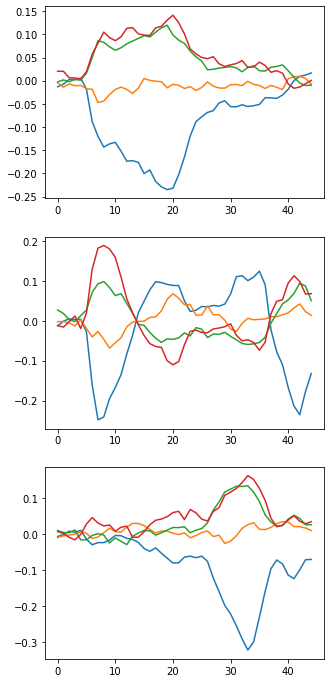

In [18]:
fig,ax=plt.subplots(3,1,figsize=(5,12))
for i in range(3):
    ax[i].plot(U[:,i].reshape(4,45).T)

variable V contains the loadings of the neurons onto each profile

&nbsp;&nbsp;&nbsp;(note that variable "V" is $V^T$ in the equation)

you could show the scatter plot of loadings

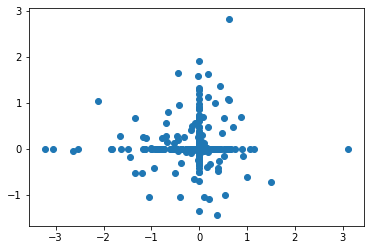

In [20]:
plt.scatter(V[0,:],V[1,:])

or calculate the kurtosis of loadings

Text(2, 80, 'kurtosis=17.14')

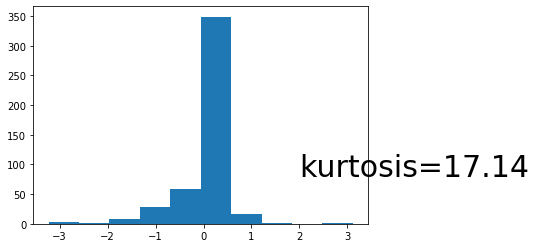

In [24]:
plt.hist(V[0,:])
plt.text(2,80,'kurtosis=%.2f'%kurtosis_centered(V[0,:]),fontsize=30)

note that V is the learned best loading that satisfies sparsity constraint, it does not equal the mere projection of data onto the learned profiles, which will fit the data slightly better but have a lot more unecessary non-zero loadings.

nevertheless, if you want to compare the kurtosis of SCA and PCA loadings, the following way of getting V is more fair

/home/xiaoxiong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'kurtosis=5.78')

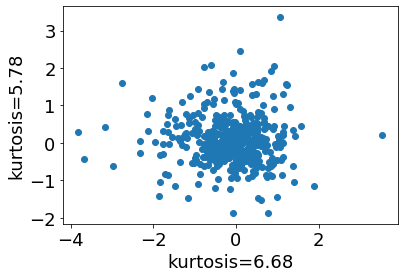

In [28]:
V_proj=np.linalg.lstsq(U,tmpX)[0]
plt.scatter(V_proj[0,:],V_proj[1,:])
plt.xlabel('kurtosis=%.2f'%kurtosis_centered(V_proj[0,:]))
plt.ylabel('kurtosis=%.2f'%kurtosis_centered(V_proj[1,:]))

# grid search

for this part it's better to run it in a .py file, coz the grid search may take a day.

if it says "out of memory" when run it in a ipython console, copying the dSCA functions into the .py file instead of importing it will solve it.

You SHOULD MODIFY it according to your data

In [32]:
from  datetime import datetime
now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

# this folder is where you have put your data and where you will store the grid search results
folder='demo'

#these are specific to my analysis, which you can just leave here or change it to your liking

#the optimization method, here I use ADMM followed by normal gradient descent. It's just a name for my log file.
version='MixOpt'
type_restructure='s100s50'
stitching='SDT'

#here you may want to iterate through all the stimuli and there interaction
for Stim in ['ST']:#['DT+SDT']:
    
    #here I wanted to compare L1 and L2 regularizer, you could just use L1
    for regu in ['L1']:#,'L2']:
        
        #this the data filename
        filename=folder+'/splitX.pkl'
        #+stitching+'_'\
        
        #here my data contains already the training and test set.
        #you could just import the raw data and split them into train and test set here
        with open(filename,'rb') as f:
            tmpX1=dill.load(f)
            tmpX2=dill.load(f)
    
        # the name for log file
        name='GS_'+Stim+'_'+stitching+'_'+regu+'_'+type_restructure+'_'+version;
        
        if regu=='L1':
            lossname='lossEla'
        else:
            lossname='lossL2'
        
        #number of runs.      if the data is well-structured, you should change this loop into repeat&fold by e.g. using the method in sklearn
        n_run=1#4
        
        max_components=3#11
        
        #how fine grained you want to explore the different alpha values in [10^alpha_s,10^alpha_e]
        n_alphas=3#80
        alpha_s=-1
        alpha_e=0.5
        
        #log training loss
        lossall=np.zeros((n_run,max_components,n_alphas));
        valossall=np.zeros((n_run,max_components,n_alphas));
        
        #log testing loss
        errall=np.zeros((n_run,max_components,n_alphas));

        
        



        os.mkdir(folder+'/ckpt_'+name)
        os.mkdir(folder+'/ckpt_'+name+'/weights')
        
        for n_run_i in range(n_run):

            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            logfile=open(folder+'/logfile_'+name+'.txt','a')
            logfile.write('n_run %d/%d   \t\t\t\t\t %s\n'%(n_run_i,n_run,current_time));
            
            #here I switched train and test set, which may not suit you (you may have more than 2 folds)
            tmpX1,tmpX2=tmpX2,tmpX1

            for j,n_components in zip(range(0,max_components),range(1,max_components+1)):
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                logfile.write('\t component %d/%d\t\t\t\t\t %s\n'%(n_components,max_components,current_time));
                for k,al in zip(range(n_alphas),np.logspace(alpha_s,alpha_e,n_alphas)):
                    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                    logfile.write('\t \t alpha %d/%d\t\t\t\t\t %s\n'%(k,n_alphas,current_time));
                    
                    
                    U,V,losses,errs=dSCA.Learn(tmpX1,tmpX2,True,n_components,al,lossname=lossname)
                        
                    #log training and validation loss
                    lossall[n_run_i,j,k]=losses[-1]
                    errall[n_run_i,j,k]=errs[-1]
                    
                    
                    
                    with open(folder+'/ckpt_'+name+'/weights/nn%02dweights%02d%02d.pkl'%(n_run_i,j,k),'wb') as f:
                        dill.dump(U,f)
                        dill.dump(V,f)
                        dill.dump(losses,f)
                        dill.dump(errs,f)

            logfile.write('\n')
            logfile.close()


        with open(folder+'/ckpt_'+name+'/losses_TrVa.pkl','wb') as f:
            dill.dump(lossall,f)
            dill.dump(errall,f)

Current Time = 23:30:11


# Best parameter

In [34]:
folder='demo'
n_iter=1200;
type_restructure='s100s50'
version='MixOpt'

for Stim in ['ST']:#,'DT']:
    for regu in ['L1']:#,'L2']:
        

    
        
        name='GS_'+Stim+'_'+stitching+'_'+regu+'_'+type_restructure+'_'+version;
        
        #load the logged losses
        with open(folder+'/ckpt_'+name+'/losses_TrVa.pkl','rb') as f:
            lossall=dill.load(f)
            errall=dill.load(f)
            
        
        #tmp is the matrix containing the loss for each parameter combination, averaged across repeats
        tmp=errall.mean(0)[:,:]
        
        #extract the best parameters which you can use to run dSCA
        n_components,ind_alpha=np.unravel_index(tmp.argmin(),tmp.shape)
        n_components+=1
        al=np.logspace(alpha_s,alpha_e,80)[ind_alpha]
        
        
        

rerun dSCA using the best parameters

In [35]:
U,V,losses,errs=dSCA.Learn(tmpX,n_components=n_components,alpha=al)
#this uses the default (arbitrary) hyperparameters, 
#you should choose your hyperparameter for a good reason, or do a grid search for it

In [13]:
U.shape

(180, 3)

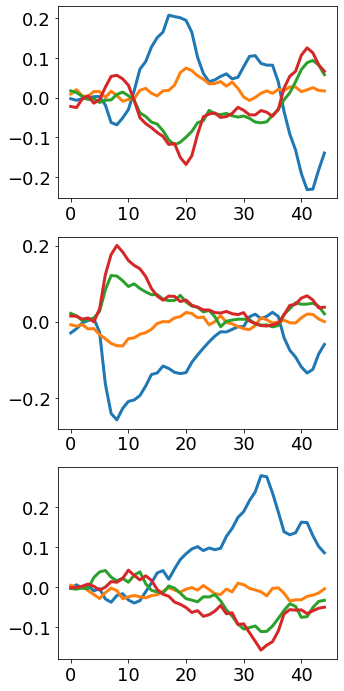

In [36]:
fig,ax=plt.subplots(3,1,figsize=(5,12))
for i in range(3):
    ax[i].plot(U[:,i].reshape(4,45).T)